In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Custom Dino and Classifier Imports
from dino_utils import prepare_data, Categories_Dataset
from dino_utils import ClassifierModel, evaluate_model, train_model
from dino_utils import set_device

Using mps as device
Using mps as device


/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
target = 'category'
fake_data_name = 'hyperstyle_embeddings'
retrain = False

### 1. Prepare Data

In [4]:
train_real, test_real = prepare_data(target, 'real_images_embeddings')
train_fake, test_fake = prepare_data(target, fake_data_name)

# Combine real and fake data
train = ConcatDataset([train_real, train_fake])
test = ConcatDataset([test_real, test_fake])

print(f"Target: {train_real.target}")
print(f"\tNumber of classes: {len(train_real.id2label)}")

print(f"\tNumber of training samples: {len(train)}")
print(f"\tNumber of testing samples: {len(test)}")

Target: category
	Number of classes: 8
	Number of training samples: 22496
	Number of testing samples: 5624


### 2. Training

In [5]:
## Model Parameters
embeddings_shape = train_real[0][0].shape[0]
num_classes = len(train_real.id2label)

## Training Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 128
LR = 5e-4
loss_fn = nn.CrossEntropyLoss()

## Initialize Model and Optimizer
device = set_device()
model = ClassifierModel(embeddings_shape, num_classes)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)

model_save_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/{target}_{fake_data_name}.pt"

Using mps as device


In [14]:
# Create dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
if retrain or not os.path.exists(model_save_path):
    train_model(model, NUM_EPOCHS, optimizer, loss_fn, train_loader, test_loader, model_save_path, device, log_every=10)
else:
    model = torch.load(model_save_path, map_location = 'cpu').to(device)

### 3. Evaluation

In [16]:
print("Overall Accuracy:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test), device)}")

print("Accuracy on real data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_real), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_real), device)}")

print("Accuracy on fake data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_fake), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_fake), device)}")

Overall Accuracy:
	Training Set: 0.9294985775248933
	Testing Set: 0.6559388335704125
Accuracy on real data:
	Training Set: 0.9434566145092461
	Testing Set: 0.6959459459459459
Accuracy on fake data:
	Training Set: 0.9155405405405406
	Testing Set: 0.615931721194879


#### Top N Accuracy

In [17]:
real_loader = DataLoader(ConcatDataset([train_real, test_real]), batch_size=BATCH_SIZE, shuffle=False)
fake_loader = DataLoader(ConcatDataset([train_fake, test_fake]), batch_size=BATCH_SIZE, shuffle=False)

In [18]:
def get_top_n_predictions(loader, n):
    predictions = {}

    for embeddings, labels, sku in loader:
        output = model(embeddings.to(device))
        prob, predicted = torch.topk(torch.softmax(output, 1), n)

        for i in range(len(predicted)):
            predictions[sku[i]] = [train_real.id2label[labels[i].item()]] + [train_real.id2label[predicted[i][j].item()] for j in range(n)] + [prob[i][j].item() for j in range(n)]

    df = pd.DataFrame(predictions).T.reset_index()
    df.columns = ['sku'] + ['target'] + [f'pred_{i}' for i in range(n)] + [f'prob_{i}' for i in range(n)]

    df['top1_correct'] = df['target'] == df['pred_0']
    for i in range(1, n):
        df[f'top{i+1}_correct'] = df[f'top{i}_correct'] | (df['target'] == df[f'pred_{i}'])
    return df


In [19]:
real_predictions = get_top_n_predictions(real_loader, 3)
fake_predictions = get_top_n_predictions(fake_loader, 3)

real_predictions['dataset'] = real_predictions.sku.apply(lambda x: 'train' if x in train_real.df.sku.to_list() else 'test')
fake_predictions['dataset'] = fake_predictions.sku.apply(lambda x: 'train' if x in train_fake.df.sku.to_list() else 'test')

In [20]:
print("Real Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {real_predictions[real_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

print("Reconstructed Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {fake_predictions[fake_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

Real Images:
	Train Set:
		Top 1: 0.9434566145092461
		Top 2: 0.9919985775248933
		Top 3: 0.9983997155049786
	Test Set:
		Top 1: 0.6959459459459459
		Top 2: 0.868421052631579
		Top 3: 0.9427453769559033
Reconstructed Images:
	Train Set:
		Top 1: 0.9155405405405406
		Top 2: 0.9830192034139402
		Top 3: 0.9959992887624467
	Test Set:
		Top 1: 0.615931721194879
		Top 2: 0.8218349928876245
		Top 3: 0.9174964438122333


In [21]:
print('Real Images:')
display(real_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False))

print('Reconstructed Images:')
fake_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False)

Real Images:


target
Denim dress                     0.964744
Day dress                       0.928258
Jumper dress                    0.924585
Occasion wear                   0.891065
Cocktail dress / Party dress    0.882786
Maxi dress                      0.847251
Shift dress                     0.828869
Jersey dress                    0.822346
Name: top1_correct, dtype: float64

Reconstructed Images:


target
Day dress                       0.900401
Jumper dress                    0.894419
Occasion wear                   0.886169
Denim dress                     0.852564
Cocktail dress / Party dress    0.847678
Maxi dress                      0.837067
Jersey dress                    0.736872
Shift dress                     0.733631
Name: top1_correct, dtype: float64

In [22]:
pd.crosstab(real_predictions.target, real_predictions.pred_0)

pred_0,Cocktail dress / Party dress,Day dress,Denim dress,Jersey dress,Jumper dress,Maxi dress,Occasion wear,Shift dress
target,,,,,,,,
Cocktail dress / Party dress,1559,101,0,18,10,20,28,30
Day dress,75,4865,2,139,40,94,4,22
Denim dress,0,8,301,0,0,2,0,1
Jersey dress,21,175,0,1472,48,40,11,23
Jumper dress,11,72,0,33,1839,15,2,17
Maxi dress,12,150,0,21,14,1248,28,0
Occasion wear,28,14,0,4,2,41,728,0
Shift dress,22,23,0,40,22,7,1,557


### Check some misclassified examples

In [23]:
def display_missclassified_samples(miss, num_samples=5):
    sample = miss.sample(num_samples)
    fig, ax = plt.subplots(1, num_samples, figsize=(5 * num_samples, 10))

    for i in range(num_samples):
        sku = sample.iloc[i].sku
        img_path = f"{DATA_PATH}/Generated_Images/hyperstyle/inference_results/4/{sku}.jpg"
        img = Image.open(img_path)
        ax[i].imshow(img)

        # Construct title string with predictions and their probabilities
        title_text = f"SKU: {sku}\nTarget: {sample.iloc[i].target}"
        for j in range(3):  # Assuming there are always three predictions to display
            pred_col = f'pred_{j}'
            prob_col = f'prob_{j}'
            title_text += f"\nPrediction {j + 1}: {sample.iloc[i][pred_col]} ({np.round(sample.iloc[i][prob_col], 2)})"

        ax[i].set_title(title_text)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync/Generated_Images/hyperstyle/inference_results/4/CIG21C04K-K11.jpg'

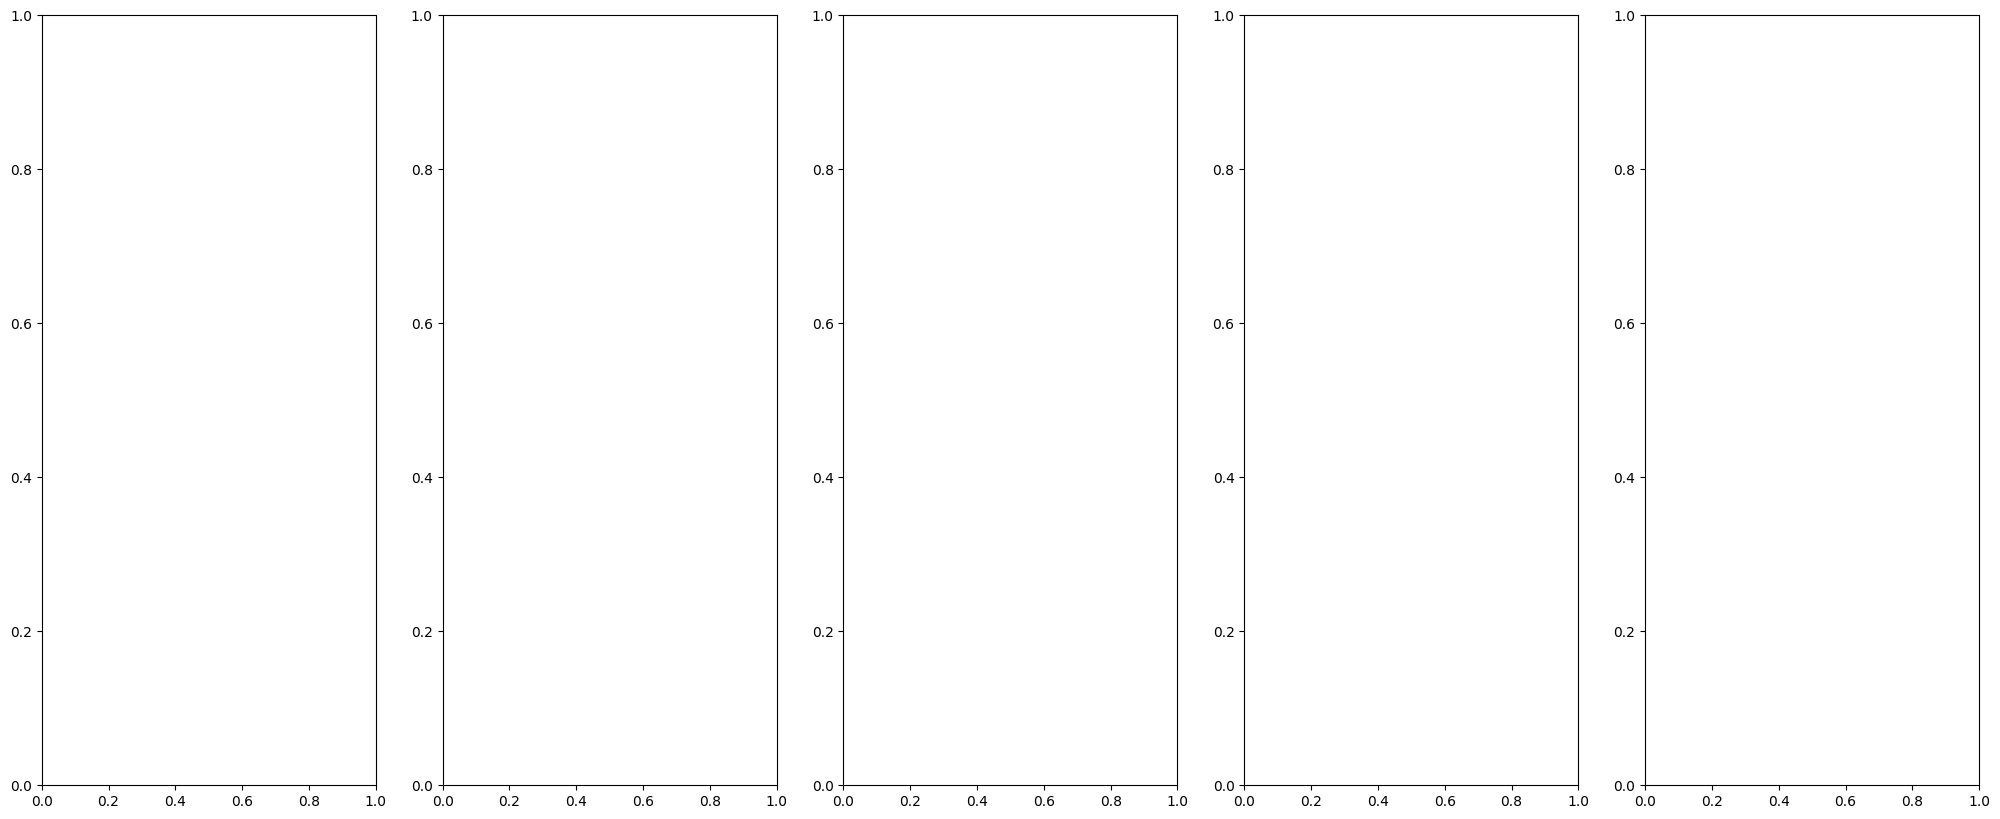

In [24]:
miss = fake_predictions[fake_predictions.target != fake_predictions.pred_0]
display_missclassified_samples(miss, 5)